In [1]:
# In[1]:


import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
from popsims import sample_from_powerlaw
import popsims
from gala.units import UnitSystem
import pandas as pd
from scipy.interpolate import interp1d, griddata, InterpolatedUnivariateSpline
from astropy.io.votable import parse_single_table
import numba
plot_style()
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm import tqdm
#get_ipython().run_line_magic('matplotlib', 'inline')


# In[2]:
from popsims.plot_style import plot_style
plot_style()


path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'

In [2]:
rgc='10_20'
fname=path_isochrone+'/simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
df=pd.read_csv(fname)

#put to the desired distance modulus 
mw_df= df.query("galaxy == 'MW'").reset_index(drop=True)
m31_df= df.query("galaxy =='M31'").reset_index(drop=True)

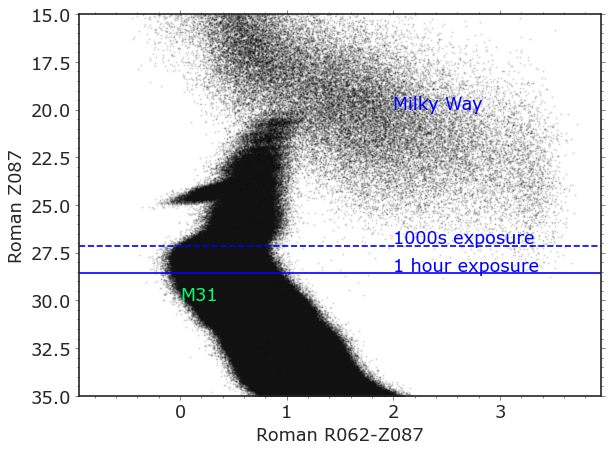

In [3]:
fig, ax=plt.subplots()

#ax.set(title='M31')
#ax.set(title='Milky Way')
p=ax.scatter(m31_df.appF062mag-m31_df.appF087mag, m31_df.appF087mag, s=1, alpha=0.1, c='#111111', label='M31 Halo')
ax.invert_yaxis()
ax.set(ylim=[35, 15])


ax.scatter(mw_df.appF062mag-mw_df.appF087mag, mw_df.appF087mag, s=1, alpha=0.1, c='k', label='Milky Way')
#ax.invert_yaxis()
#ax[1].set(ylim=[35, 15])

#for a in ax:
ax.axhline(28.59, linestyle='-', c='b')
ax.axhline(27.15, linestyle='--', c='b')
ax.set(xlabel= 'Roman R062-Z087', ylabel='Roman Z087')

#plt.tight_layout()
#cax = fig.add_axes([0.08, 0., .3, 0.04])
#plt.colorbar(p, ax=ax, cax=cax, orientation='horizontal')
#cax.set(xlabel=r'[M/H]')
#ax.legend(markerscale=20)
#ax.text()
ax.text(2., 20, "Milky Way",c='b', fontsize=16)
ax.text(0., 30, "M31",c='#01FF70', fontsize=16)

ax.text(2., 27.15-0.15, "1000s exposure",c='b', fontsize=16)
ax.text(2, 28.69-0.2, "1 hour exposure",c='b', fontsize=16)


ax.minorticks_on()
plt.tight_layout()
plt.savefig('../figures/simulated_CMD_Roman_M31.jpeg', bbox_inches='tight')

In [4]:
#check luminosity functions 
rgc='10_20'
fname=path_isochrone+'/simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
df=pd.read_csv(fname)

from astropy.io.votable import parse_single_table
path_pandas= '/users/caganze/research/stellarstreams/data/pandas/'
data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()

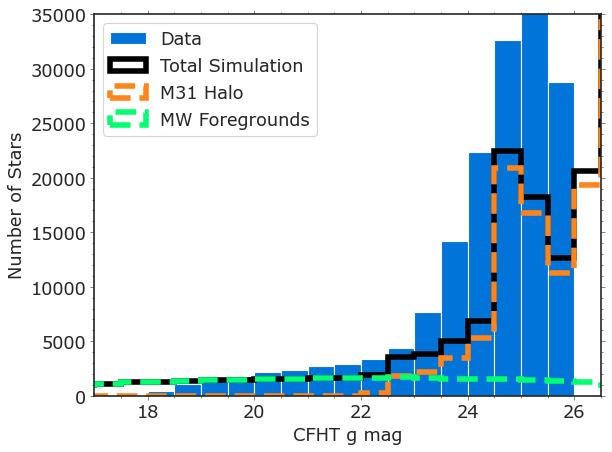

In [5]:
fig, ax=plt.subplots()
_= plt.hist(data.g, bins= np.arange(15, 27, 0.5), log=False, label='Data', color='#0074D9')
_= plt.hist(df.appgmag.values,
            bins= np.arange(15, 30, 0.5), log=False, histtype='step', linewidth=5, \
            label='Total Simulation', linestyle='-', color='k')
_= plt.hist(df.appgmag[df.galaxy.values == 'M31'].values,
            bins= np.arange(15, 30, 0.5), log=False, histtype='step',\
            linestyle='--', linewidth=5, label='M31 Halo', color='#FF851B')

_= plt.hist(df.appgmag[df.galaxy.values == 'MW'].values,
            bins= np.arange(15, 30, 0.5), log=False, histtype='step', linewidth=5, \
            label='MW Foregrounds', linestyle='--', color='#01FF70')


ax.set(xlabel='CFHT g mag', ylabel='Number of Stars', ylim=[0, 35_000], xlim=[17, 26.5])
ax.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig('../figures/lf_check_rgc{}.jpeg'.format(rgc), bbox_inches='tight')

simulated_CMD_CFHT_rgc10_20.jpeg


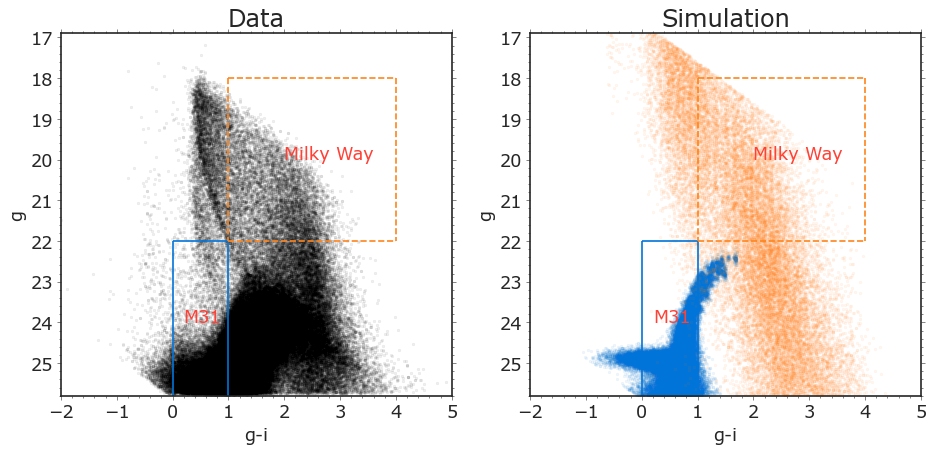

In [6]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 6))
rgc='10_20'
ax[0].scatter(data.g-data.i, data.g, c='k', s=1, marker=',', alpha=0.05)
df0= df[np.logical_and.reduce([df.appgmag.values <data.g.max(), \
                       df.appgmag.values >data.g.min(),\
                        df.appimag.values >data.i.min(),\
                       df.appimag.values < data.i.max(),
                       (df.galaxy.values == 'M31')]) ]

df1= df[np.logical_and.reduce([df.appgmag.values <data.g.max(), \
                       df.appgmag.values >data.g.min(),\
                        df.appimag.values >data.i.min(),\
                       df.appimag.values < data.i.max(),
                       (df.galaxy.values == 'MW')]) ]
ax[1].scatter(df0.appgmag-df0.appimag, df0.appgmag, s=1, marker=',', alpha=0.05, label='M31',  color='#0074D9')
ax[1].scatter(df1.appgmag-df1.appimag, df1.appgmag, s=1, marker=',', alpha=0.05, label='MW', color='#FF851B')

#ax[1].vlines()
for a in ax:
    a.set(xlabel='g-i', ylabel='g', xlim=[-2, 5])
    a.minorticks_on()
    
    a.hlines(22, xmin=0., xmax=1., color='#0074D9')
    a.vlines(0, ymin=22., ymax=26., color='#0074D9')
    a.vlines(1, ymin=22., ymax=26., color='#0074D9')
    
    
    a.hlines(22, xmin=1., xmax=4., color='#FF851B', linestyle='--')
    a.hlines(18, xmin=1., xmax=4., color='#FF851B', linestyle='--')
    a.vlines(1, ymin=18., ymax=22., color='#FF851B', linestyle='--')
    a.vlines(4, ymin=18., ymax=22.,color='#FF851B', linestyle='--')
    
    a.text(2., 20, "Milky Way",c='#FF4136', fontsize=16)
    a.text(0.2, 24, "M31",c='#FF4136', fontsize=16)
    a.set(ylim=[data.g.max(), data.g.min()])
    
#ax[-1].legend()
#ax[-1].legend(markerscale=20)
ax[-1].minorticks_on()
ax[0].set(title='Data')
ax[1].set(title='Simulation')

plt.tight_layout()
plt.savefig('../figures/simulated_CMD_CFHT_rgc{}.jpeg'.format(rgc),  bbox_inches='tight')
print('simulated_CMD_CFHT_rgc{}.jpeg'.format(rgc))

In [7]:
def count_densities(rgc):
    fname=path_isochrone+'/simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
    df=pd.read_csv(fname)
           
    df0=df[df.appF087mag<28.69]

    from astropy.io.votable import parse_single_table
    path_pandas= '/users/caganze/research/stellarstreams/data/pandas/'
    data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
    
    df1=df.query('appimag > {} & appimag< {}  & appgmag > {} & appgmag< {}'.format(*(data.i.min(), data.i.max(), data.g.min(), data.g.max())))
    
    print ('-----------------CFHT data-------------')
    print ((len(data)/2.8)/1e4)
    
    print ('-----------------CFHT simulated---------')
    print ((len(df1)/2.8)/1e4)
    
    print ('------------------Roman------------------------')
    print ((len(df0)/2.8)/1e4)

In [8]:
for rgc in ['10_20', '30_40', '50_60']:
    print (rgc)
    count_densities(rgc)

10_20
-----------------CFHT data-------------
6.130571428571429
-----------------CFHT simulated---------
2.905392857142857
------------------Roman------------------------
51.82803571428572
30_40
-----------------CFHT data-------------
2.256107142857143
-----------------CFHT simulated---------
1.5285000000000002
------------------Roman------------------------
15.25232142857143
50_60
-----------------CFHT data-------------
2.4106428571428573
-----------------CFHT simulated---------
1.457857142857143
------------------Roman------------------------
11.345964285714286


In [9]:
2.4/1.4

1.7142857142857144